# Retrieve spectra using Simple Spectral Access protocol

This notebook is one of a set produced by NAVO to demonstrate data access with python tools. 

In this notebook, we show how to search for and retrieve spectra from VO services using the Registry and the __[Simple Spectral Access](http://www.ivoa.net/documents/SSA/)__ (SSA) protocol.


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  
import requests, io
from astropy.table import Table
import astropy.io.fits as fits

from navo_utils.registry import Registry
from navo_utils.spectra import Spectra, SpectraColumn

from astropy.coordinates import SkyCoord

# Surpress known innocuous warnings
import warnings
warnings.filterwarnings("ignore", module="astropy.io.votable.*")

First, we find out what spectral acess services are available in the Registry offering x-ray data:

In [2]:
services=Registry.query(service_type='spectr',waveband='x-ray')
services

waveband,short_name,ivoid,res_description,access_url,reference_url,publisher,service_type
str56,str14,str49,str678,str71,str58,str36,str20
x-ray,Chandra,ivo://nasa.heasarc/chanmaster,No Description Available,https://heasarc.gsfc.nasa.gov/xamin/vo/ssa?table=chanmaster&amp;,https://heasarc.gsfc.nasa.gov/W3Browse/all/chanmaster.html,NASA/GSFC HEASARC,simplespectralaccess
x-ray#gamma-ray,HEAVENS @ ISDC,ivo://wfau.roe.ac.uk/heavens_at_isdc/light-curves,"With time, all HEAVENS products should become available on the Virtual Observatory. In some cases this requires an enhancement of the Virtual Observatory standards. For now the following HEAVENS services are available through the VO: - SIAP Image cutout service for INTEGRAL/ISGRI and JEM-X - Timeseries service for INTEGRAL/ISGRI, JEM-X and OMC Wished features include: - Extended Query Parameters for time intervals - Extended Query Parameters for energy bands - Timeseries service for INTEGRAL/IREM and SPI-ACS - Spectra service for all INTEGRAL instruments",http://www.isdc.unige.ch/vo-services/lc?,http://www.isdc.unige.ch/heavens/,WFAU,simplespectralaccess
radio#millimeter#infrared#optical#uv#euv#x-ray#gamma-ray,NED/SED,ivo://ned.ipac/sed_data_near_position,"NED SED Information Discovery Request service: The NASA/IPAC Extragalactic Database (NED) provides a comprehensive fusion of multi-wavelength data for hundreds of millions of objects located beyond the Milky Way galaxy. This service retrieves photometry for objects within a specified radius of a given position. The search region is specified by two parameters: POS [RA and DEC in decimal degrees, ICRF/FK5J2000] and SIZE [degrees]. This service returns a list of NED Object Identifiers (Names), the count of photometric SED measurements for each object, and the URI (ACREF) for the SED Data Retrieval request (accessSED). This service is used by the VO SED analysis tool Iris.",http://vo.ned.ipac.caltech.edu/services/querySED?REQUEST=queryData&amp;,http://ned.ipac.caltech.edu/help/data_help.html#ptmydat,The NASA/IPAC Extragalactic Database,simplespectralaccess
gamma-ray#x-ray,INTEGRAL/BSC,ivo://nasa.heasarc/intbsc,No Description Available,https://heasarc.gsfc.nasa.gov/xamin/vo/ssa?table=intbsc&amp;,https://heasarc.gsfc.nasa.gov/W3Browse/all/intbsc.html,NASA/GSFC HEASARC,simplespectralaccess


We can look at only the Chandra entry:

In [3]:
chan_tables = services[np.isin(services['short_name'],['Chandra'])]
chan_tables['short_name', 'access_url']

short_name,access_url
str14,str71
Chandra,https://heasarc.gsfc.nasa.gov/xamin/vo/ssa?table=chanmaster&amp;


## Chandra Spectrum of the Delta Ori

In [4]:
delori=SkyCoord.from_name("delta ori")
pos='{},{}'.format(delori.ra.deg,delori.dec.deg)

spec_tables=Spectra.query(service=chan_tables[0],coords=pos,radius=0.1,verbose=True)

spec_tables[0]['time'].format='.4f'
spec_tables[0].show_in_notebook()



    Querying service https://heasarc.gsfc.nasa.gov/xamin/vo/ssa?table=chanmaster&amp;
    Got 6 results for parameters[0]


idx,obsid,status,name,ra,dec,time,detector,grating,exposure,type,pi,public_date,SSA_start_time,SSA_tmid,SSA_stop_time,SSA_duration,SSA_ra,SSA_dec,SSA_coord_obs,SSA_title,SSA_reference,SSA_datalength,SSA_datamodel,SSA_instrument,SSA_publisher,SSA_format,SSA_fov,SSA_wavelength_min,SSA_wavelength_max,SSA_bandwidth,SSA_bandpass
,,,,deg,deg,mjd,,,s,,,mjd,mjd,mjd,mjd,s,deg,deg,deg,,,,,,,,deg,meter,meter,meter,meter
0,639,archived,DELTA ORI,83.00125,-0.29917,51556.1364,ACIS-S,HETG,49680,GO,Cassinelli,52037,51556.1364,51556.43650057151,51556.735856340485,49680.0,83.00125,-0.29917,--,acisf00639N004_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao01/cat2/639/primary/acisf00639N004_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.81,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
1,7416,archived,delta Ori HD 36486,83.00167,-0.29908,54413.4270,HRC-S,LETG,97080,GO,Raassen,54783,54413.427,54413.99748095434,54414.56715379722,97080.0,83.00167,-0.29908,--,hrcf07416N003_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao08/cat2/7416/primary/hrcf07416N003_pha2.fits.gz,2.0,Spectrum-1.0,HRC-S,HEASARC,application/fits,0.81,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
2,14567,archived,Delta Ori,83.00167,-0.29908,56280.7037,ACIS-S,HETG,116500,GO,Corcoran,56647,56280.7037,56281.38982472211,56282.07517784063,116500.0,83.00167,-0.29908,--,acisf14567N002_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao14/cat2/14567/primary/acisf14567N002_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.81,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
3,14568,archived,Delta Ori,83.00167,-0.29908,56288.1612,ACIS-S,HETG,123600,GO,Corcoran,56655,56288.1612,56288.89025076302,56289.61850203206,123600.0,83.00167,-0.29908,--,acisf14568N002_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao14/cat2/14568/primary/acisf14568N002_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.81,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
4,14569,archived,Delta Ori,83.00167,-0.29908,56283.2540,ACIS-S,HETG,120850,GO,Corcoran,56650,56283.254,56283.96498017049,56284.67520199699,120850.0,83.00167,-0.29908,--,acisf14569N002_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao14/cat2/14569/primary/acisf14569N002_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.81,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
5,14570,archived,Delta Ori,83.00167,-0.29908,56285.5508,ACIS-S,HETG,124100,GO,Corcoran,56652,56285.5508,56286.28389746857,56287.016223824656,124100.0,83.00167,-0.29908,--,acisf14570N002_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao14/cat2/14570/primary/acisf14570N002_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.81,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09


In [5]:
hdu_list=Spectra.get_fits(spec_tables[0][5])
# Or write it to disk
Spectra.get_fits(spec_tables[0][5],filename='downloads/chandra_spectrum.fits')

FITS spectrum written to downloads/chandra_spectrum.fits



## Simple example of plotting a spectrum

In [6]:
spec_table=Table(hdu_list[1].data)
spec_table

SPEC_NUM,TG_M,TG_PART,TG_SRCID,X,Y,CHANNEL [8192],COUNTS [8192],STAT_ERR [8192],BACKGROUND_UP [8192],BACKGROUND_DOWN [8192],BIN_LO [8192],BIN_HI [8192]
int16,int16,int16,int16,float32,float32,int16,int16,float32,int16,int16,float64,float64
1,-3,1,1,4113.775,4083.7346,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,7.159166666667378 .. 0.3333333333333333,7.160000000000712 .. 0.33416666666666667
2,-2,1,1,4113.775,4083.7346,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,10.738750000000886 .. 0.5,10.740000000000887 .. 0.50125
3,-1,1,1,4113.775,4083.7346,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,21.477500000001772 .. 1.0,21.480000000001773 .. 1.0025
4,1,1,1,4113.775,4083.7346,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,21.477500000001772 .. 1.0,21.480000000001773 .. 1.0025
5,2,1,1,4113.775,4083.7346,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,10.738750000000886 .. 0.5,10.740000000000887 .. 0.50125
6,3,1,1,4113.775,4083.7346,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,7.159166666667378 .. 0.3333333333333333,7.160000000000712 .. 0.33416666666666667
7,-3,2,1,4113.775,4083.7346,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,13.985000000001373 .. 0.3333333333333333,13.98666666666804 .. 0.33499999999999996
8,-2,2,1,4113.775,4083.7346,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,20.977500000001505 .. 0.5,20.980000000001507 .. 0.5025
9,-1,2,1,4113.775,4083.7346,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,41.95500000000301 .. 1.0,41.960000000003014 .. 1.005


/Users/donald/anaconda/envs/navo/lib/python3.6/site-packages/matplotlib/axes/_base.py:3507: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  self.set_ylim(upper, lower, auto=None)


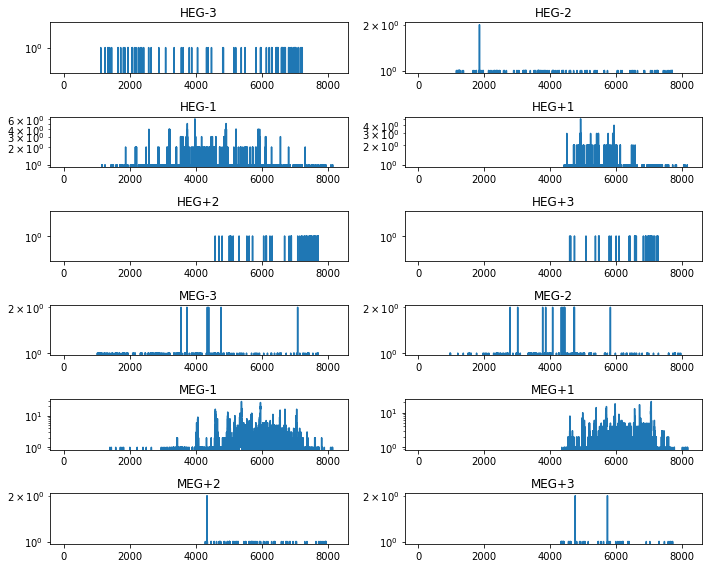

In [7]:
for i in range(len(spec_table)):
    matplotlib.rcParams['figure.figsize'] = (10, 8)
    ax=plt.subplot(6,2,i+1)
    pha = plt.plot( spec_table['CHANNEL'][i],spec_table['COUNTS'][i])
    ax.set_yscale('log')
    if spec_table['TG_PART'][i] == 1:
        instr='HEG'
    if spec_table['TG_PART'][i] == 2:
        instr='MEG'
    if spec_table['TG_PART'][i] == 3:
        instr='LEG'
    ax.set_title("{grating}{order:+d}".format(grating=instr, order=spec_table['TG_M'][i]))
    plt.tight_layout()


This can then be analyzed in your favorite spectral analysis tool, e.g., [pyXspec](https://heasarc.gsfc.nasa.gov/xanadu/xspec/python/html/index.html).  (For the winter 2018 AAS workshop, we demonstrated this in a [notebook](https://github.com/NASA-NAVO/aas_workshop_2018/blob/master/heasarc/heasarc_Spectral_Access.ipynb) that you can consult for how to use pyXspec, but the pyXspec documentation will have more information.)  